# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Logistic Regression</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Weighted Log-Likelihood</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance"
]

target = 'is_bad'

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

In [119]:
from matplotlib import pyplot as plt
from scipy.special import logit
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({"font.size": 12})

weights = []
sns.set_style('white')

def ks_stat(y, yhat):
    return ks_2samp(yhat[y == 1], yhat[y != 1]).statistic # type: ignore

def plot_densities(model, X, y, sample_weight, model_type="logistic"):
    for sample_w in sample_weight:
        if model_type == "gbdt":
            model = xgb.XGBClassifier(
                n_estimators=300,
                max_depth=2,
                colsample_bynode=0.8,
                learning_rate=0.05,
                subsample=0.8,
            )
        else:
            model = LogisticRegression(fit_intercept=True, max_iter=1000, penalty=None)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        sample_weights = y_train.map({0: sample_w, 1: 1})
        model.fit(X_train, y_train, sample_weight=sample_weights)
        
        if model_type == "logistic":
            weights.append(model.coef_)
            
        probabilities = model.predict_proba(X_test)[:, 1]
        logit_scores = logit(probabilities)
        
        pdo, odds, target_score = 20, 10, 600
        if model_type == "gbdt":
            pdo, odds, target_score = 20, 10, 1000
        factor = pdo / np.log(2)
        offset = target_score - factor * np.log(odds)
        scores = -logit_scores * factor + offset        
        scores -= scores.mean()
        scores /= scores.std()
        scores -= -6.5
        scores *= 9

        pos_logit = scores[y_test == 1]
        neg_logit = scores[y_test == 0]

        gini = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) * 2 - 1
        ks_statistic = ks_stat(y_test, model.predict_proba(X_test)[:, 1])

        _, ax1 = plt.subplots(1, 1, figsize=(8, 6))
        
        ax1.set_xlim(0, 100)
        
        common_kde_params = dict(
            fill=True, alpha=0.6, linewidth=0.0, bw_method=2.0, bw_adjust=0.5
        )
        

        ax1.spines["right"].set_visible(False)
        ax1.spines["top"].set_visible(False)
        
        # add background color to the ax1
        ax1.set_facecolor('white')
        
        ax1.tick_params(axis="x", length=0)
        ax1.tick_params(axis="y", length=0)

        sns.kdeplot(pos_logit, label="Not approved", ax=ax1, color="#a801ff", common_norm=True, **common_kde_params) # type: ignore
        sns.kdeplot(neg_logit, label="Approved", ax=ax1, color="#a7fe01",common_norm=True, **common_kde_params) # type: ignore
        
        ax1.legend(fontsize=12)

        ax1.set_xlabel("Credit score")
        ax1.set_ylabel("Density")
        ax1.set_title(f"W = {sample_w:.4f}")
        
        ax1.legend(title='Approval Status', loc='upper left', bbox_to_anchor=(1, 1))

        metrics_text = (
            f"Gini (CV) = {gini:.2%}\n"
            f"KS (CV) = {ks_statistic:.2%}"
        )

        box_x_position = 0.05
        box_y_position = 0.95

        ax1.text(
            box_x_position, box_y_position,
            metrics_text, fontsize=12,
            transform=ax1.transAxes,
            horizontalalignment='left', verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round,pad=0.5')
        )

        plt.tight_layout()
        plt.show()

In [120]:
sample_weight_vector = [1e-3, 1e-1, 1e-0, 1e1, 1e3, 1e5]

model = LogisticRegression(fit_intercept=True, max_iter=1000, penalty=None)

plot_densities(model, X.loc[ix_train], y.loc[ix_train], sample_weight_vector, model_type='logistic')

### Decision Boundary

In [148]:
from matplotlib import pyplot as plt
from matplotlib.pylab import f
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

weights = []

sns.set_style('white')

def ks_stat(y, yhat):
    return ks_2samp(yhat[y == 1], yhat[y != 1]).statistic  # type: ignore

monotonicity = (1, -1)

def plot_decision_boundary(model, X, y, paired_features, sample_weight, model_type="logistic"):
    
    fit_intercept_param = True

    for sample_w in sample_weight:
        
        if model_type == "gbdt":
            model = xgb.XGBClassifier(
                n_estimators=300,
                reg_lambda=2.0,
                max_depth=2,
                learning_rate=0.05,
                subsample=0.6,
                monotone_constraints=monotonicity,
            )
        else:
            model = LogisticRegression(
                fit_intercept=fit_intercept_param,
                penalty='l2',
                C=1.0,
                max_iter=1000
            )

        sample_weights = np.where(y == 0, sample_w, 1)

        # Fit model using only specified paired features
        model.fit(X[paired_features], y, sample_weight=sample_weights)
        
        if model_type == "logistic":
            weights.append(model.coef_)

        plt.figure(figsize=(8, 6))

        feature_1, feature_2 = np.meshgrid(
            np.linspace(X[paired_features[0]].min(), X[paired_features[0]].max()),
            np.linspace(X[paired_features[1]].min(), X[paired_features[1]].max())
        )

        grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

        y_pred = np.reshape(
            model.predict_proba(grid)[:, 1],
            feature_1.shape
        )
        

        display = DecisionBoundaryDisplay(
            xx0=feature_1, 
            xx1=feature_2, 
            response=y_pred,
        )

        display.plot()
        
        scatter = display.ax_.scatter(
            X[paired_features[0]], 
            X[paired_features[1]], 
            c=y,
            edgecolors='k',
            s=10,
        )

        unique_labels = np.unique(y)
        for unique_label in unique_labels:
            class_desc = 'Approved' if unique_label == 0 else 'Not Approved'
            plt.scatter(
                [], [], color=scatter.cmap(scatter.norm(unique_label)), label=f"{class_desc}" # type: ignore
            )

        # Place the legend outside the plot area
        plt.legend(title="Approval Status", loc='upper left', bbox_to_anchor=(1, 1))

        # Calculate Gini index
        gini = roc_auc_score(y, model.predict_proba(X[paired_features])[:, 1]) * 2 - 1
        
        plt.xlabel('Card usage')
        plt.ylabel('% Days with positive balance')
        
        
        if model_type == "logistic":
            plt.suptitle(f'W = {sample_w:.4f}, Gini = {gini:.2%}', y=1.00)
            plt.title(
                f"Weight 1 = {model.coef_.ravel()[0]:.2f}, "
                f"Weight 2 = {model.coef_.ravel()[1]:.2f}"
                f", Bias = {model.intercept_[0]:.2f}" if fit_intercept_param else "",
            )
        else:
            plt.suptitle(f'W = {sample_w:.4f}, Gini = {gini:.2%}', y=1.00)
            plt.title(
                f"Estimators = {model.n_estimators}, " # type: ignore
                f"Max depth = {model.max_depth}, " # type: ignore
                f"Monotonicity = {model.monotone_constraints}" # type: ignore
            )
        plt.show()

<Figure size 800x600 with 0 Axes>

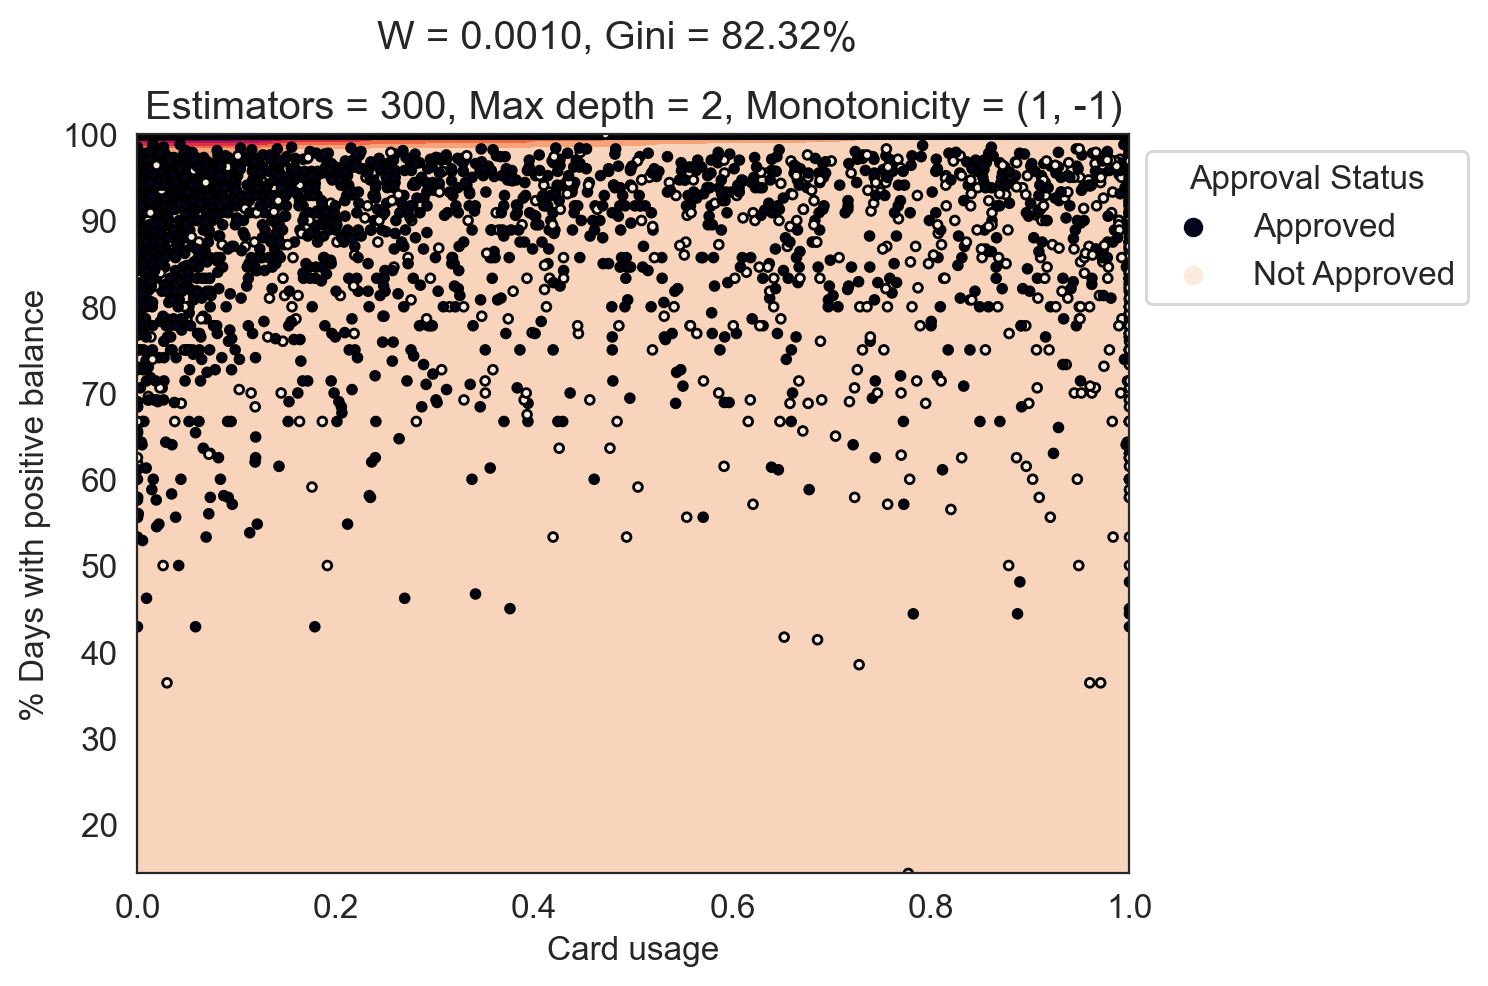

<Figure size 800x600 with 0 Axes>

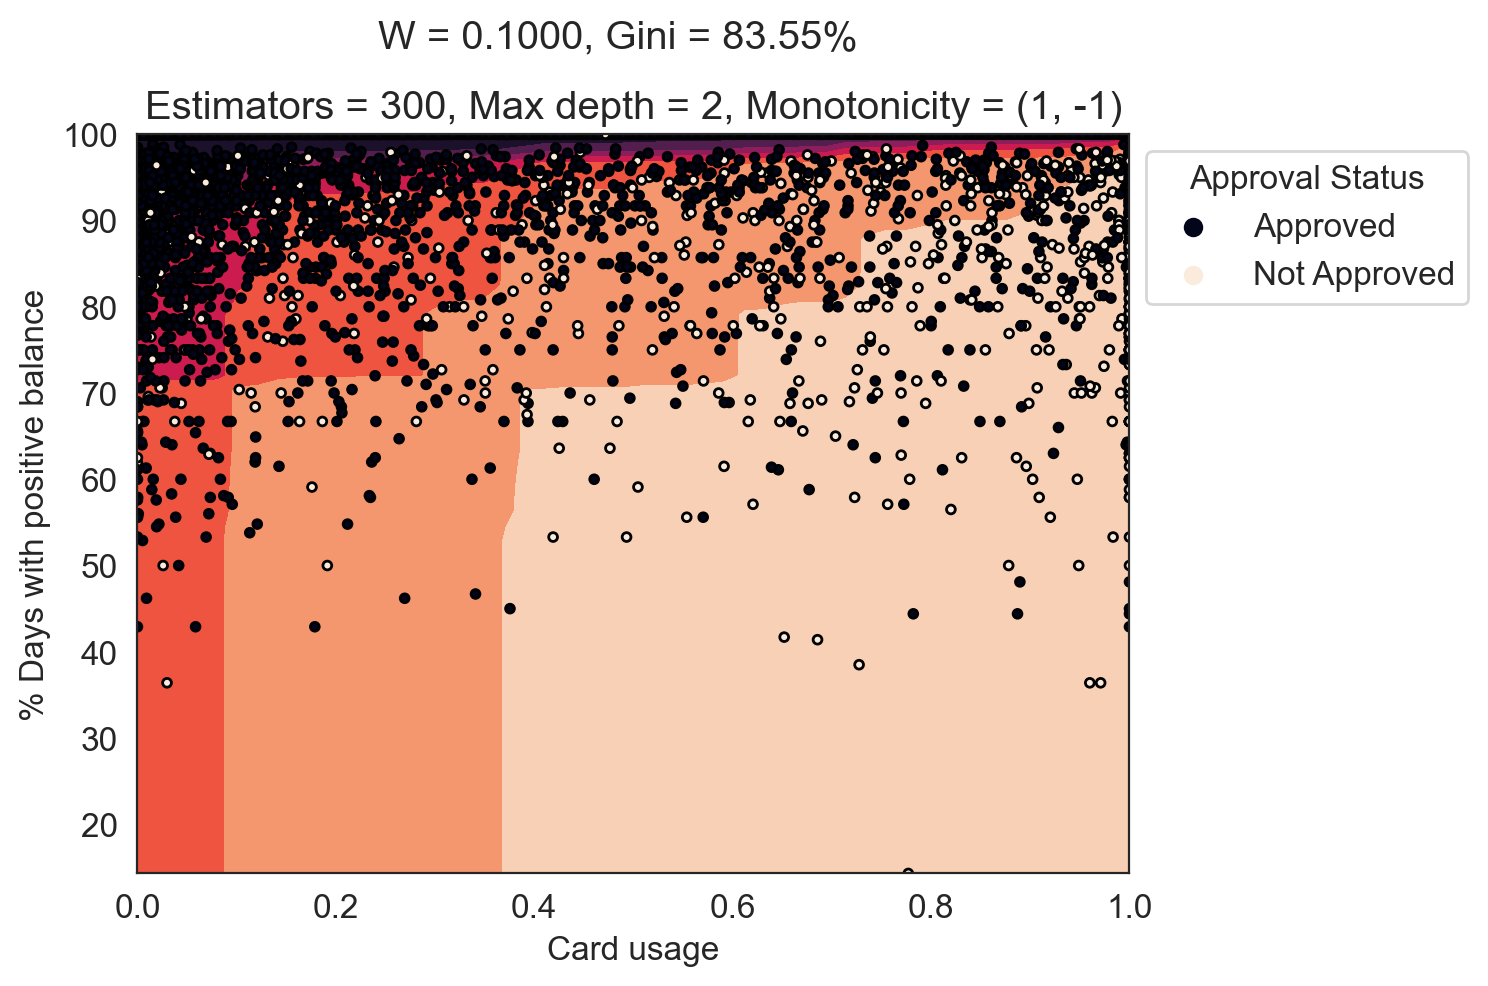

<Figure size 800x600 with 0 Axes>

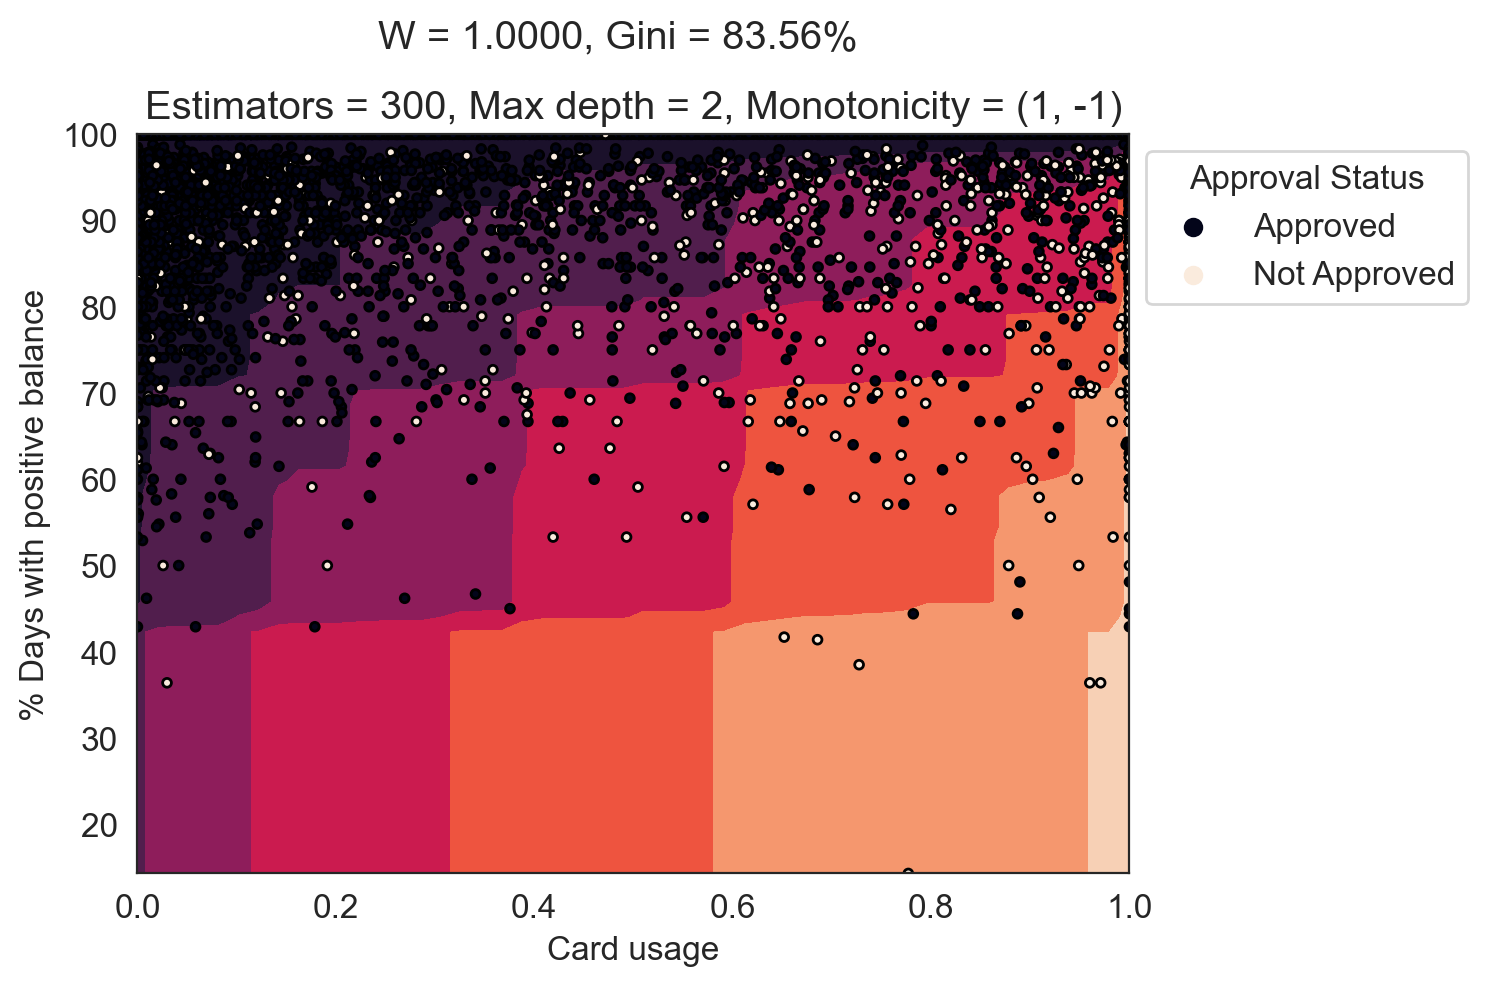

<Figure size 800x600 with 0 Axes>

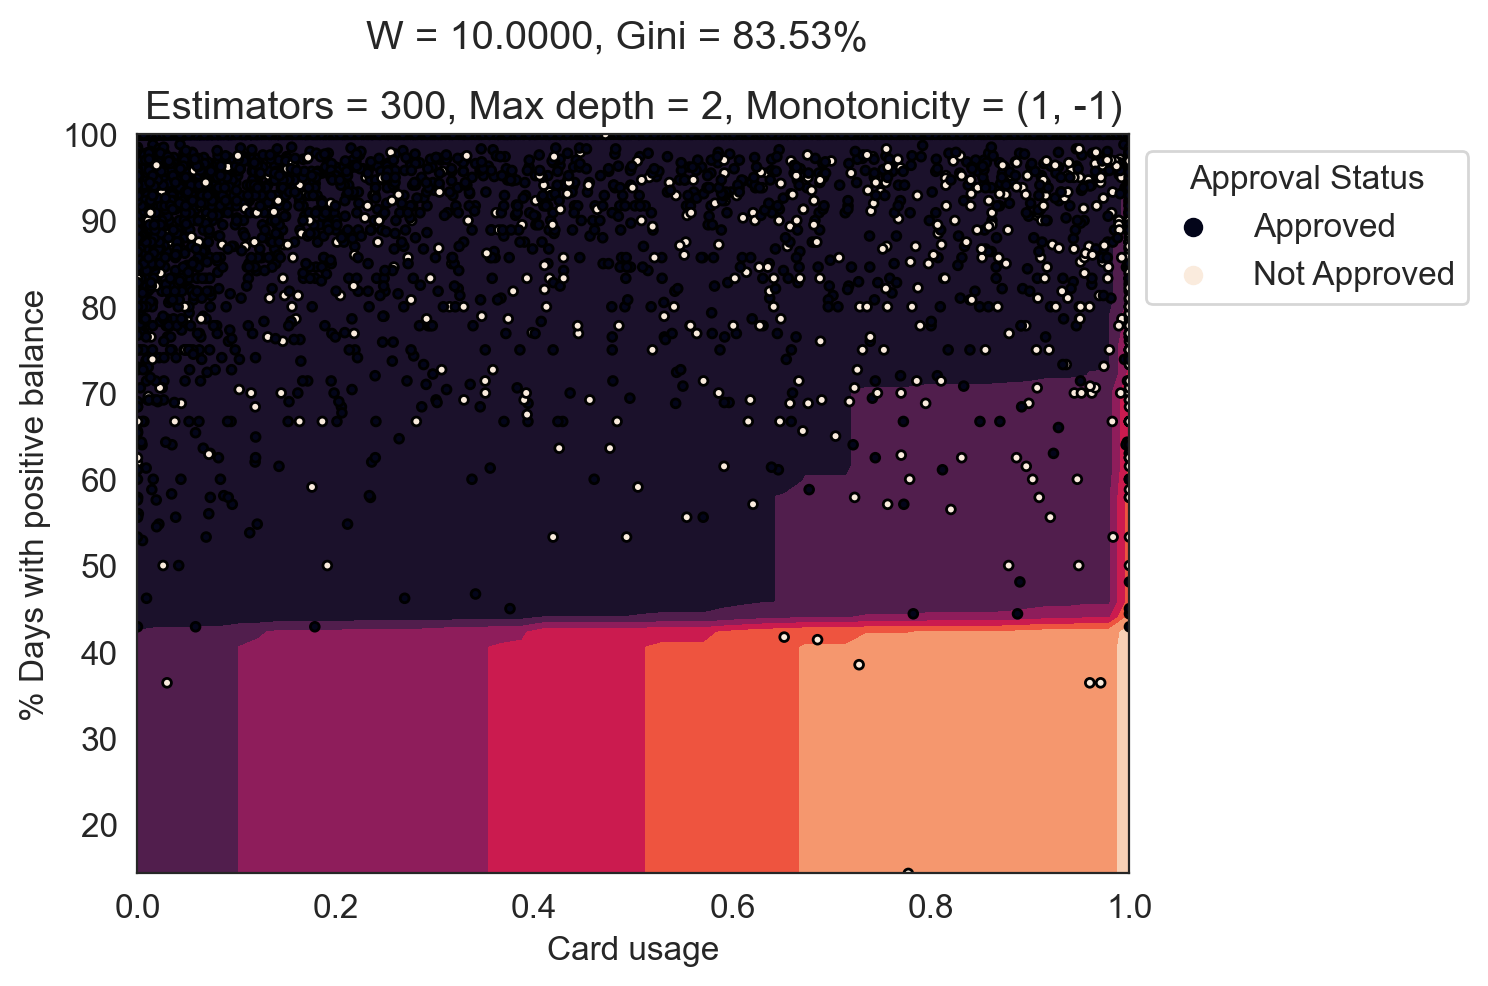

<Figure size 800x600 with 0 Axes>

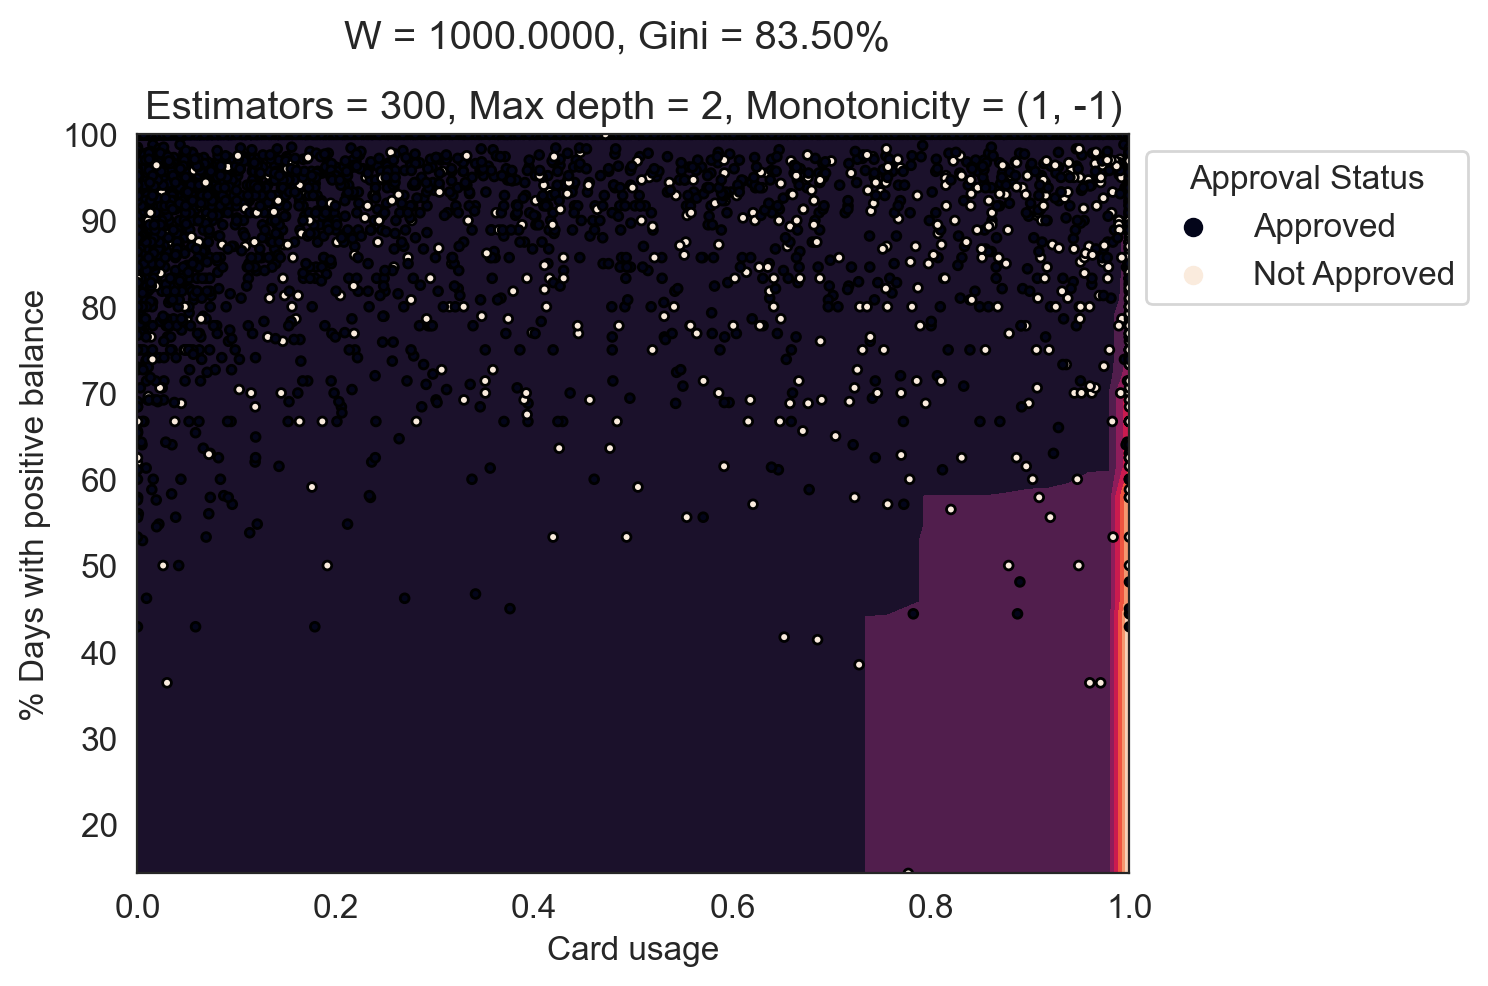

<Figure size 800x600 with 0 Axes>

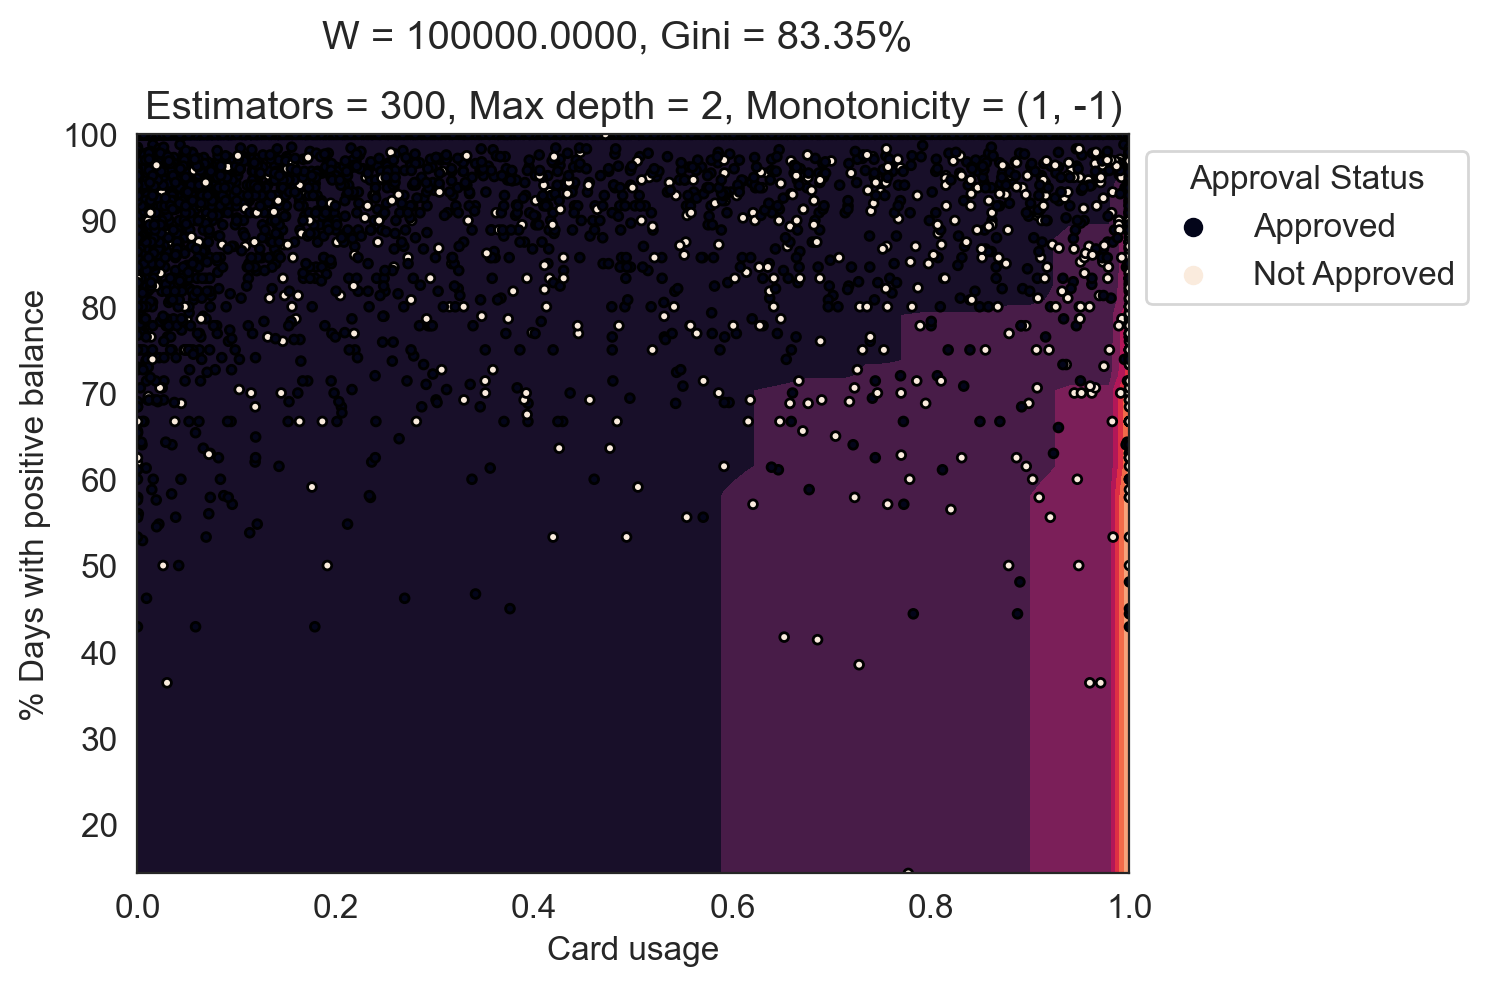

In [150]:
sample_weight_vector = [1e-3, 1e-1, 1e-0, 1e1, 1e3, 1e5]

# plot_densities(model, X.loc[ix_train], y.loc[ix_train], sample_weight_vector)
plot_decision_boundary(model, X.loc[ix_train], y.loc[ix_train], X.iloc[:,: 2].columns.tolist(), sample_weight_vector, model_type='gbdt')